In [17]:
%cd ~
import pyfits,glob,time,scipy, sys
from scipy.special import erf
from pylab import *
from subprocess import call
from scipy.optimize import fmin_powell
from scipy.ndimage import gaussian_filter, convolve
from scipy import stats

topdir='/Users/cslage/Research/LSST/code/BF_Kernel_08May18/'
forwarddir = topdir+'forward_model_varying_i/'
%cd $forwarddir
import  forward
datadir=topdir+'data/'

%cd $topdir


/Users/cslage
/Users/cslage/Research/LSST/code/BF_Kernel_08May18/forward_model_varying_i
/Users/cslage/Research/LSST/code/BF_Kernel_08May18


In [18]:
# Get the image data
zfilelist=sort(glob.glob(datadir+'ITL-3800C-029_spot_spot_2??_20170330??????_ct.fits'))
print len(zfilelist)

5


In [19]:
def remove_overscan_xy(image,x_overscan_start,x_overscan_end,y_overscan_start,y_overscan_end):
    overscan=image[:y_overscan_start,x_overscan_start+1:x_overscan_end]
    image=image[:y_overscan_start,:x_overscan_start]
    finalimg=image-matrix(median(overscan,axis=1)).T*np.ones(shape(image)[1])
    return array(finalimg)

class Array2dSet:
    def __init__(self,xmin,xmax,nx,ymin,ymax,ny,nstamps):
        # This packages up a set of nstamps postage stamp images,
        # each image of which is nx * ny pixels
        self.nx=nx
        self.ny=ny
        self.nstamps=nstamps

        self.xmin=xmin
        self.ymin=ymin
        
        self.xmax=xmax
        self.ymax=ymax
        
        self.dx=(xmax-xmin)/nx
        self.dy=(ymax-ymin)/ny
        
        self.x=linspace(xmin+self.dx/2,xmax-self.dx/2,nx)
        self.y=linspace(ymin+self.dy/2,ymax-self.dy/2,ny)

        self.data=zeros([nx,ny,nstamps])
        self.xoffset=zeros([nstamps])
        self.yoffset=zeros([nstamps])
        self.imax=zeros([nstamps])


def BuildSpotList(fitsfilename, segmentnumber, numspots, nx, ny, minsize, maxsize):
    stampxmin = -(int(nx/2)+0.5)
    stampxmax = -stampxmin
    stampymin = -(int(ny/2)+0.5)
    stampymax = -stampymin
    xcoomin = 50
    xcoomax = 450
    ycoomin = 1200
    ycoomax = 1900
    spotlist = Array2dSet(stampxmin,stampxmax,nx,stampymin,stampymax,ny,numspots)
    hdr=pyfits.getheader(fitsfilename,segmentnumber)
    extname = hdr['EXTNAME']
    img=pyfits.getdata(fitsfilename,extname) 
    overscansubimg=remove_overscan_xy(img,509,542,2000,2022) 
    catname=fitsfilename[:-5]+extname+'.fits.cat.reg' 
    catfile = open(catname,'r')
    catlines = catfile.readlines()
    catfile.close()
    n=0
    for line in catlines:
        try:
            size = float(line.split()[3].split('#')[0])
            if size < minsize or size > maxsize:
                continue
            xcoord = float(line.split()[1])
            ycoord = float(line.split()[2])
            if xcoord < xcoomin or xcoord > xcoomax or ycoord < ycoomin or ycoord > ycoomax:
                continue
            xint = int(xcoord-0.5)
            yint = int(ycoord-0.5)
            xmin = xint - int(nx/2)
            xmax = xint + int(nx/2) + 1
            ymin = yint - int(ny/2)
            ymax = yint + int(ny/2) + 1
            stamp = overscansubimg[ymin:ymax, xmin:xmax]
           
            xsum = 0.0
            ysum = 0.0
            datasum = 0.0
             
            for i in range(nx):
                for j in range(ny):
                    spotlist.data[i,j,n] = float(stamp[j,i])                    
                    ysum += spotlist.y[j] * spotlist.data[i,j,n]
                    xsum += spotlist.x[i] * spotlist.data[i,j,n]
                    datasum += spotlist.data[i,j,n]
            xoff = xsum / datasum
            yoff = ysum / datasum
            spotlist.xoffset[n] = xoff
            spotlist.yoffset[n] = yoff
            n += 1
            if n == numspots:
                return spotlist
        except:
            continue
    # Reaching this point means we found less spots than requested.
    newspotlist = Array2dSet(stampxmin,stampxmax,nx,stampymin,stampymax,ny,n)
    newspotlist.xoffset = spotlist.xoffset[0:n]
    newspotlist.yoffset = spotlist.yoffset[0:n]
    newspotlist.data = spotlist.data[:,:,0:n]
    del spotlist
    return newspotlist


def Area(xl, xh, yl, yh, sigmax, sigmay, Imax):
    # Calculates how much of a 2D Gaussian falls within a rectangular box
    ssigx = sqrt(2) * sigmax
    ssigy = sqrt(2) * sigmay    
    I = (erf(xh/ssigx)-erf(xl/ssigx))*(erf(yh/ssigy)-erf(yl/ssigy))
    return Imax * I / 4.0


def FOM(params):
    [sigmax, sigmay] = params
    result = forward.forward(spotlist,sigmax,sigmay)
    return result

def PyFOM(params):
    # This is a Python implementation of the Figure of Merit (FOM) implemented in the forward code
    # It is not normally used
    fom = 0.0
    [Imax, sigmax, sigmay] = params
    area=zeros([spotlist.nx,spotlist.ny])
   
    for spot in range(spotlist.nstamps):
        for ii in range(spotlist.nx):
            for jj in range(spotlist.ny):
                xl = spotlist.x[ii] - spotlist.xoffset[spot] - 0.5
                xh = xl + 1.0
                yl = spotlist.y[jj] - spotlist.yoffset[spot] - 0.5
                yh = yl + 1.0
                area[ii,jj] = Area(xl, xh, yl, yh, sigmax, sigmay, Imax)
                fom += square(area[ii,jj]-spotlist.data[ii,jj,spot])
    return fom


/Users/cslage/Research/LSST/code/BF_Kernel_08May18/data/ITL-3800C-029_spot_spot_250_20170330092825_ct.fits
nstamps = 400
Optimization terminated successfully.
         Current function value: 23157312867.549007
         Iterations: 3
         Function evaluations: 77
[1.05413718 1.07316225]


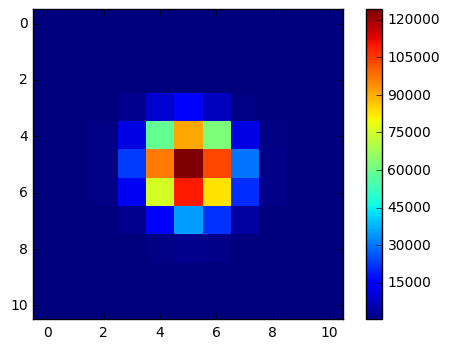

In [27]:
# Check the spotlist building
nx = 11
ny = 11
numspots =400
spotnum = 4
segmentnumber = 5

fitsfilename = zfilelist[-1]
print fitsfilename
    
spotlist = BuildSpotList(fitsfilename, segmentnumber, numspots, nx, ny, 0.7, 1.4)
print "nstamps = %d"%spotlist.nstamps
args = ()#(spotlist)
param0 = [1.0, 1.0]
OldResult = fmin_powell(FOM, param0, args)
print OldResult

spot = 4.0 * spotlist.data[:,:,spotnum] # Convert to electrons
imshow(spot, interpolation='nearest')
colorbar()
show()

#### Now extract the kernel.  We can extract it from either the measured data or from the simulated spot areas.  For this test, we'll use the simulated spot areas.

In [21]:
class Array2d:
    def __init__(self,xmin,xmax,nx,ymin,ymax,ny):
        # Each image is nx * ny pixels
        self.nx=nx
        self.ny=ny

        self.xmin=xmin
        self.ymin=ymin
        
        self.xmax=xmax
        self.ymax=ymax
        
        self.dx=(xmax-xmin)/nx
        self.dy=(ymax-ymin)/ny
        
        self.x=linspace(xmin+self.dx/2,xmax-self.dx/2,nx)
        self.y=linspace(ymin+self.dy/2,ymax-self.dy/2,ny)

        self.cov=zeros([nx,ny])
        self.kernel=zeros([nx,ny])        

def ReadConfigFile(filename):
    # This reads the Poisson simulator config file for
    # the settings that were run
    # and returns a dictionary with the values

    with open(filename,'r') as file:
        lines=file.readlines()
    lines = [ l.strip() for l in lines ]
    lines = [ l.split() for l in lines if len(l) > 0 and l[0] != '#' ]
    for line in lines:
        if line[1] != '=':
            print "Check line: ",line
            raise IOError("Error reading config file %s"%filename)
    config = {}
    for line in lines:
        try:
            # First get the ordered pairs
            config.update({line[0]:[eval(line[2]), eval(line[3])]})
        except:
            try:
                # Then get the numeric values
                config.update({line[0]:eval(line[2])})
            except:
                try:
                    # Last, get the strings
                    config.update({line[0]:str(line[2])})
                except:
                    pass
    return config


def ReadAreaFile(filename, arr, Area_0, NxCenter, NyCenter):
    # This reads the simulated pixel area file
    # and returns an array with the covariances
    file = open(filename, 'r')
    lines = file.readlines()
    file.close()
    lines.remove(lines[0]) # Strip the title line    
    for line in lines:
        items = line.split()
        i = int(items[0])
        j = int(items[1])
        area = float(items[2])
        ii = i + (arr.nx - 1)/2 - NxCenter 
        jj = j + (arr.ny - 1)/2 - NyCenter 
        arr.cov[ii,jj] += (area - Area_0) / Area_0
    return arr

def ReadMeasurementFile(filename, arr):
    # This reads the measured correlation data file
    # and returns an array with the covariances
    file = open(filename, 'r')
    lines = file.readlines()
    file.close()
    lines.remove(lines[0]) # Strip the title line
    for i in range(3):
        lines.remove(lines[-1]) # Strip the last three lines

    for line in lines:
        items = line.split()
        i = int(items[0])
        j = int(items[1])
        cov = float(items[2])
        if (i > 0 or j > 0) and cov < 0.0:
            cov = 0.0
        for xsign in [-1,1]:
            ii = i * xsign + (arr.nx - 1)/2
            for ysign in [-1,1]:
                jj = j * ysign + (arr.ny - 1)/2
                arr.cov[jj,ii] = cov
    return arr


def SOR(arr, w):
    hsquared =  arr.dx * arr.dy;
    omw = 1.0 - w;
    w4 = w / 4.0
    for i in range(1, arr.nx-1):
        for j in range(1, arr.ny-1):
	    arr.kernel[i,j] = omw * arr.kernel[i,j] + w4 * (arr.kernel[i-1,j] + arr.kernel[i+1,j] + arr.kernel[i,j-1] + arr.kernel[i,j+1] + hsquared * arr.cov[i,j])
    return arr
  

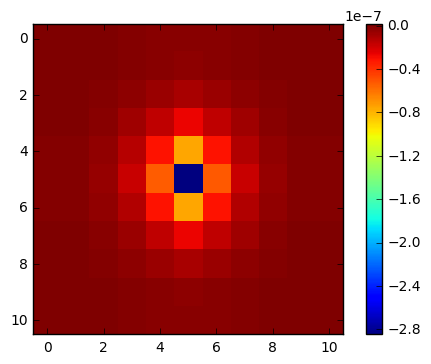

In [22]:
# First, read the .cfg file to get all of the parameters
configfile = datadir+'pixel.cfg'
run = 0
ConfigData = ReadConfigFile(configfile)
outputfilebase = ConfigData["outputfilebase"]
outputfiledir = ConfigData["outputfiledir"]
Nx = ConfigData["PixelBoundaryNx"]
Ny = ConfigData["PixelBoundaryNy"]
XCenter = ConfigData["FilledPixelCoords_0_0"][0]
YCenter = ConfigData["FilledPixelCoords_0_0"][1]
PixelSizeX = ConfigData["PixelSizeX"]
PixelSizeY = ConfigData["PixelSizeY"]
NxCenter = int((XCenter - ConfigData["PixelBoundaryLowerLeft"][0]) / PixelSizeX)
NyCenter = int((YCenter - ConfigData["PixelBoundaryLowerLeft"][1]) / PixelSizeY)
Area_0 = 99.994058# Nominally 100.0, running with no charge gives 99.99745. this value minimizes sum(cov)
NumElec = ConfigData["CollectedCharge_0_0"]
NewNx = NewNy = 21
NewNxCenter = (NewNx - 1) / 2
NewNyCenter = (NewNy - 1) / 2

# Get the covariance data
filename = outputfiledir + '/' + outputfilebase +'_%d_Area'%run + '.dat'
kernel = Array2d(0,NewNx,NewNx,0,NewNy,NewNy)
kernel = ReadAreaFile(filename, kernel, Area_0, NxCenter, NyCenter)
kernel.cov /= NumElec

# Now invert using SOR to calculate the kernel
w = 1.9
for n in range(1000):
    kernel = SOR(kernel,w)

# Here's a 2D plot of the kernel
imshow(kernel.kernel[5:16,5:16], interpolation='nearest')
colorbar()
show()

In [23]:
# Now implement the correction
# Trying 4th order corrections
def Dx(image):
    dx = zeros(image.shape)
    for i in range(2,image.shape[0]-2):
        for j in range(image.shape[1]):
            dx[i,j] = (-image[i+2,j] + 8.0 * image[i+1,j] - 8.0 * image[i-1,j] + image[i-2,j])/12.0
    return dx

def Dy(image):
    dy = zeros(image.shape)
    for i in range(image.shape[0]):
        for j in range(2,image.shape[1]-2):
            dy[i,j] = (-image[i,j+2] + 8.0 * image[i,j+1] - 8.0 * image[i,j-1] + image[i,j-2])/12.0
    return dy

def D2(image):
    d2 = zeros(image.shape)
    for i in range(1,image.shape[0]-1):
        for j in range(1,image.shape[1]-1):
            d2[i,j] = (4.0 * (image[i+1,j] + image[i-1,j] + image[i,j+1] + image[i,j-1]) + \
                       (image[i+1,j+1] + image[i+1,j-1] + image[i-1,j+1] + image[i-1,j-1]) - \
                       20.0 * image[i,j]) / 6.0
    return d2

def Correction(data, kernel):
    int_term = convolve(data,kernel,mode='constant',cval=0.0)
    term1 = Dx(data) * Dx(int_term) + Dy(data)* Dy(int_term)
    term2 = data * D2(int_term)
    correction = (term1 + term2) / 2.0
    #print data.sum(), kernel.sum(), int_term.sum(), correction.sum()
    return correction



Finished spot 0, Numsteps to converge = 7, Correction Sum = -245.844183
Finished spot 100, Numsteps to converge = 6, Correction Sum = -277.842016
Finished spot 200, Numsteps to converge = 7, Correction Sum = -232.347705
Finished spot 300, Numsteps to converge = 7, Correction Sum = -210.913873
Optimization terminated successfully.
         Current function value: 22225629044.586349
         Iterations: 3
         Function evaluations: 83
Old Sigmas =  [1.05413718 1.07316225] New Sigmas =  [1.04255808 1.06021532]


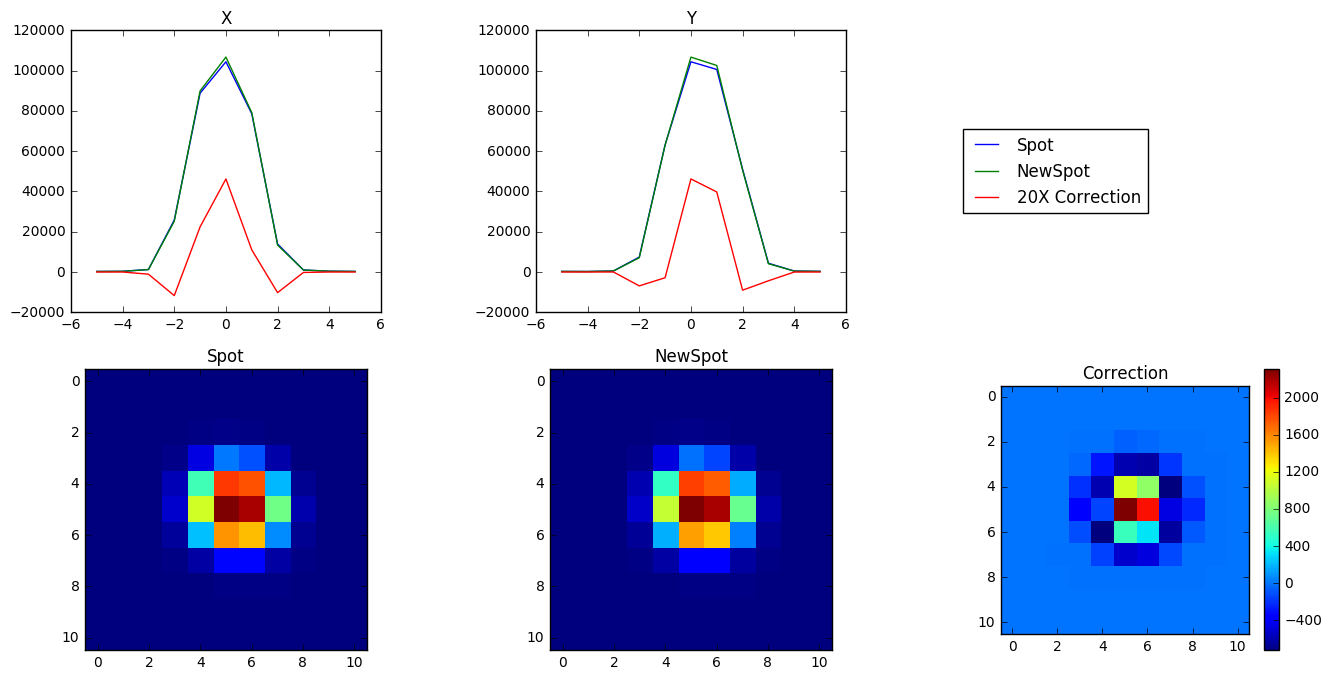

In [29]:
# test the correction implementation on a single spotlist
figure(figsize=(16,8))
subplots_adjust(wspace=0.5)

gain = 3.5
for spot in range(spotlist.nstamps):
    newspot = copy(gain * spotlist.data[:,:,spot])
    correction = zeros(newspot.shape)
    diff = 100.0
    numsteps = 0
    # Iterate to convergence
    while diff > 1.0E-6:
        lastcorrection = copy(correction)
        correction = Correction(newspot, kernel.kernel)
        newspot = gain * spotlist.data[:,:,spot] + correction
        diff = ((lastcorrection - correction) * (lastcorrection - correction)).sum()
        #print "Diff = %f"%diff
        numsteps += 1
    if spot % 100 == 0:
        print "Finished spot %d, Numsteps to converge = %d, Correction Sum = %f"\
        %(spot,numsteps, correction.sum()) 
    
    if spot == spotlist.nstamps - 1:  # Plot the last one, with correction
        subplot(2,3,1)
        title("X")
        plot(spotlist.x, spotlist.data[:,5,-1] * gain, label='Spot')
        plot(spotlist.x, newspot[:,5], label='NewSpot')
        plot(spotlist.x, 20*correction[:,5], label='20X Correction')
        subplot(2,3,2)
        title("Y")
        plot(spotlist.y, spotlist.data[5,:,-1] * gain, label='Spot')
        plot(spotlist.y, newspot[5,:], label='NewSpot')
        plot(spotlist.y, 20*correction[5,:], label='20X Correction')
        legend(loc='center right', bbox_to_anchor=(2.0, 0.5))
        subplot(2,3,4)
        title("Spot")
        imshow(spotlist.data[:,:,-1] * gain, interpolation = 'nearest')
        subplot(2,3,5)
        title("NewSpot")
        imshow(newspot, interpolation = 'nearest')
        subplot(2,3,6)
        title("Correction")
        imshow(correction, interpolation = 'nearest')
        colorbar()

    for i in range(spotlist.nx):
        for j in range(spotlist.ny):
            spotlist.data[i,j,spot] = newspot[i,j] / gain

args = ()#(spotlist)
param0 = [1.0, 1.0]
Result = fmin_powell(FOM, param0, args)
print "Old Sigmas = ", OldResult,"New Sigmas = ", Result

show()


In [30]:
# Now let's try it with a full list of spots
import gc
nx = 11
ny = 11
numspots = 400
numfiles = len(zfilelist)
sigmaxs = zeros([4,numfiles])
sigmays = zeros([4,numfiles])
imaxs = zeros([4,numfiles])
totelectrons = zeros([4,numfiles])
corr_sigmaxs = zeros([4,numfiles])
corr_sigmays = zeros([4,numfiles])
corr_imaxs = zeros([4,numfiles])
corr_totelectrons = zeros([4,numfiles])

gains = [5.03,5.04,4.94,5.03]

for i, segmentnumber in enumerate([5,6,12,14]):
    gain = gains[i]

    for j,fitsfilename in enumerate(zfilelist):

        # First run the forward modeling on the uncorrected spotlist
        param0 = [1.0, 1.0]
        spotlist = BuildSpotList(fitsfilename, segmentnumber, numspots, nx, ny,0.7,2.0)
        print "nstamps = %d"%spotlist.nstamps
        args = ()#(spotlist)
        Result = fmin_powell(FOM, param0, args)

        print fitsfilename
        imax = spotlist.imax.mean()
        ADU_correction = Area(-0.5,0.5,-0.5,0.5,Result[0],Result[1],1.0)
        tote = spotlist.data.sum() * gain / spotlist.nstamps # Total electrons in the stamp
        print "Uncorrected:",Result, imax, tote
        imaxs[i,j] = imax * ADU_correction * gain
        sigmaxs[i,j] = abs(Result[0])
        sigmays[i,j] = abs(Result[1])
        totelectrons[i,j] = tote

        # Now apply the correction and recalculate the forward modeling
        for spot in range(spotlist.nstamps):
            newspot = copy(gain * spotlist.data[:,:,spot])
            correction = zeros(newspot.shape)
            diff = 100.0
            numsteps = 0
            # Iterate to convergence
            while diff > 1.0E-6:
                lastcorrection = copy(correction)
                correction = Correction(newspot, kernel.kernel) # 2X Fudge Factor in kernel???
                newspot = gain * spotlist.data[:,:,spot] + correction
                diff = ((lastcorrection - correction) * (lastcorrection - correction)).sum()
                #print "Diff = %f"%diff
                numsteps += 1
            for ii in range(spotlist.nx):
                for jj in range(spotlist.ny):
                    spotlist.data[ii,jj,spot] = newspot[ii,jj] / gain
            if spot % 100 == 0:
                print "Finished spot %d, Numsteps to converge = %d"%(spot, numsteps)
        args = ()#(spotlist)
        param0 = [1.0, 1.0]
        Result = fmin_powell(FOM, param0, args)
        imax = spotlist.imax.mean()
        ADU_correction = Area(-0.5,0.5,-0.5,0.5,Result[0],Result[1],1.0)
        tote = spotlist.data.sum() * gain / spotlist.nstamps # Total electrons in the stamp
        print "Corrected",Result, imax, tote
        corr_imaxs[i,j] = imax * ADU_correction * gain
        corr_sigmaxs[i,j] = abs(Result[0])
        corr_sigmays[i,j] = abs(Result[1])
        corr_totelectrons[i,j] = tote
        del spotlist
        gc.collect()



nstamps = 400
Optimization terminated successfully.
         Current function value: 902218041.244068
         Iterations: 3
         Function evaluations: 81
/Users/cslage/Research/LSST/code/BF_Kernel_08May18/data/ITL-3800C-029_spot_spot_210_20170330090208_ct.fits
Uncorrected: [1.04035107 1.05744664] 58145.64903879636 284264.9987375
Finished spot 0, Numsteps to converge = 5
Finished spot 100, Numsteps to converge = 5
Finished spot 200, Numsteps to converge = 5
Finished spot 300, Numsteps to converge = 5
Optimization terminated successfully.
         Current function value: 889947433.566179
         Iterations: 3
         Function evaluations: 86
Corrected [1.03675812 1.05341394] 58108.25236310431 284242.84417465015
nstamps = 400
Optimization terminated successfully.
         Current function value: 3417927680.737874
         Iterations: 3
         Function evaluations: 79
/Users/cslage/Research/LSST/code/BF_Kernel_08May18/data/ITL-3800C-029_spot_spot_220_20170330090613_ct.fits
Uncorre

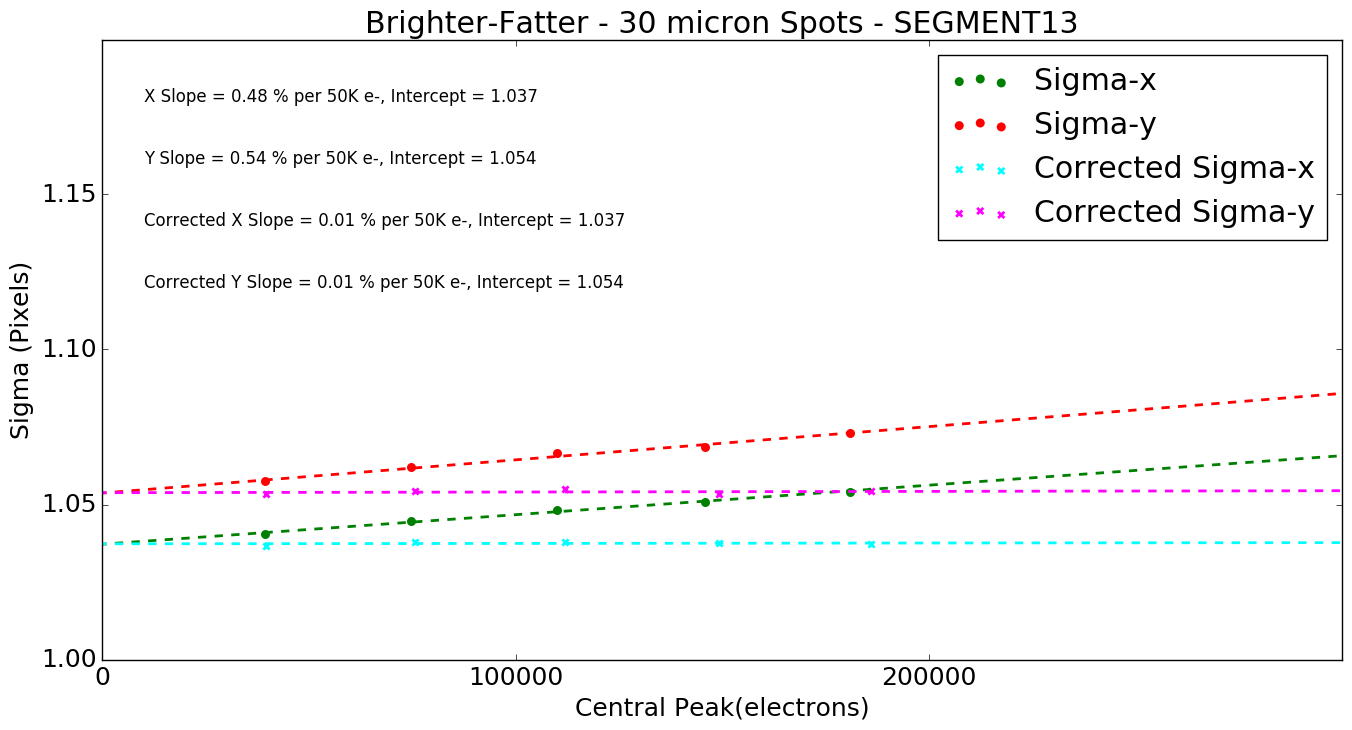

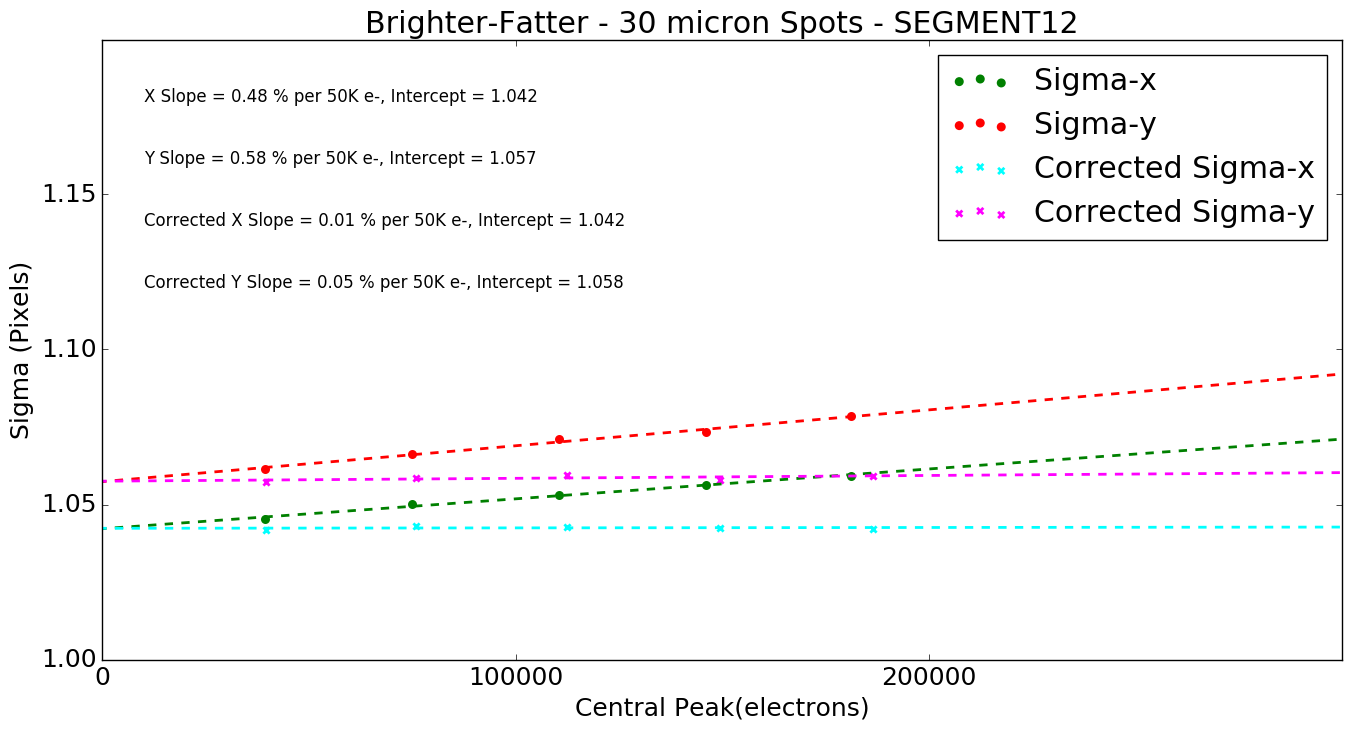

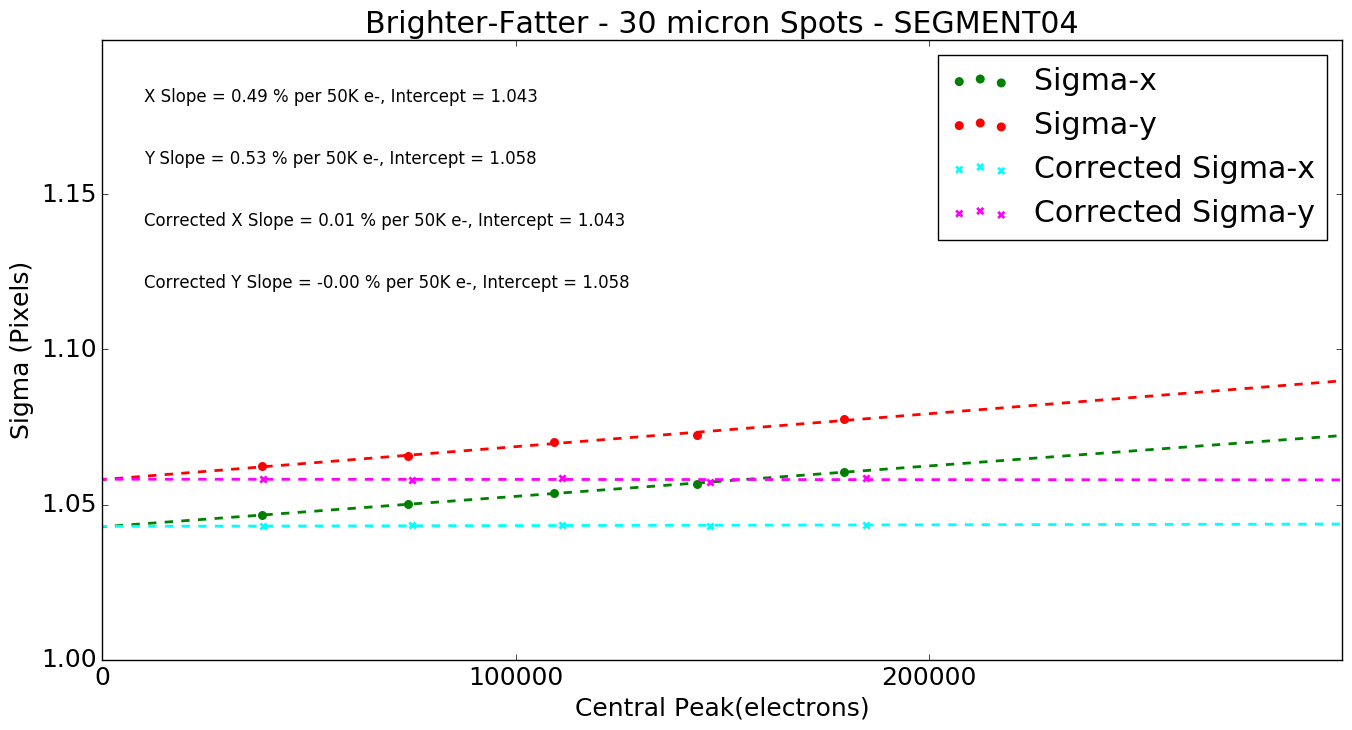

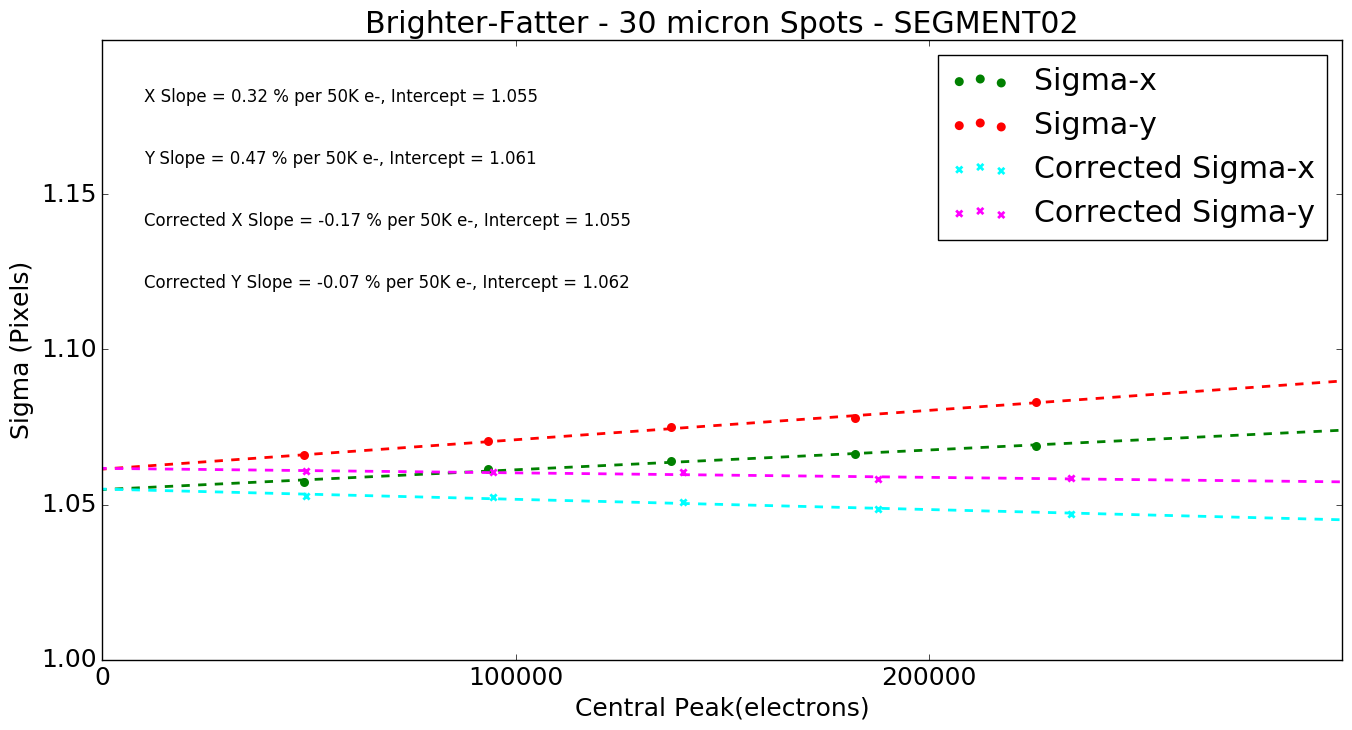

In [32]:
# Now plot the result
rcParams.update({'font.size':18})
# The following masks out bad fits files of undetermined cause, probably due to the shutter sticking
mask = []#[18,19,21,22,24,25] # Use this one 

for i, segmentnumber in enumerate([5,6,12,14]):
    hdr=pyfits.getheader(zfilelist[0],segmentnumber)
    extname = hdr['EXTNAME']

    figure(figsize=(16,8))
    title("Brighter-Fatter - 30 micron Spots - %s"%extname)
    # First plot the uncorrected data
    scatter(delete(imaxs[i,:],mask), delete(sigmaxs[i,:],mask), color = 'green', lw = 2, label = 'Sigma-x')
    scatter(delete(imaxs[i,:],mask), delete(sigmays[i,:],mask), color = 'red', lw = 2, label = 'Sigma-y')

    slope, intercept, r_value, p_value, std_err = stats.linregress(imaxs[i,:],sigmaxs[i,:])
    xplot=linspace(-5000.0,300000.0,100)
    yplot = slope * xplot + intercept
    plot(xplot, yplot, color='green', lw = 2, ls = '--')
    tslope = slope * 100.0 * 50000.0
    text(10000.0,1.18,"X Slope = %.2f %% per 50K e-, Intercept = %.3f"%(tslope,intercept), fontsize=12)

    slope, intercept, r_value, p_value, std_err = stats.linregress(imaxs[i,:],sigmays[i,:])
    xplot=linspace(-5000.0,300000.0,100)
    yplot = slope * xplot + intercept
    plot(xplot, yplot, color='red', lw = 2, ls = '--')
    tslope = slope * 100.0 * 50000.0
    text(10000.0,1.16,"Y Slope = %.2f %% per 50K e-, Intercept = %.3f"%(tslope,intercept), fontsize=12)

    # Now plot the corrected data
    scatter(delete(corr_imaxs[i,:],mask), delete(corr_sigmaxs[i,:],mask), color = 'cyan', lw = 2, marker = 'x',label = 'Corrected Sigma-x')
    scatter(delete(corr_imaxs[i,:],mask), delete(corr_sigmays[i,:],mask), color = 'magenta', lw = 2, marker = 'x', label = 'Corrected Sigma-y')

    slope, intercept, r_value, p_value, std_err = stats.linregress(corr_imaxs[i,:],corr_sigmaxs[i,:])
    xplot=linspace(-5000.0,300000.0,100)
    yplot = slope * xplot + intercept
    plot(xplot, yplot, color='cyan', lw = 2, ls = '--')
    tslope = slope * 100.0 * 50000.0
    text(10000.0,1.14,"Corrected X Slope = %.2f %% per 50K e-, Intercept = %.3f"%(tslope,intercept), fontsize=12)

    slope, intercept, r_value, p_value, std_err = stats.linregress(corr_imaxs[i,:],corr_sigmays[i,:])
    xplot=linspace(-5000.0,300000.0,100)
    yplot = slope * xplot + intercept
    plot(xplot, yplot, color='magenta', lw = 2, ls = '--')
    tslope = slope * 100.0 * 50000.0
    text(10000.0,1.12,"Corrected Y Slope = %.2f %% per 50K e-, Intercept = %.3f"%(tslope,intercept), fontsize=12)

    xlim(0.0,300000.0)
    xticks([0,100000,200000])
    ylim(1.00,1.20)
    xlabel('Central Peak(electrons)')
    ylabel('Sigma (Pixels)')
    legend(loc= 'upper right')#, bbox_to_anchor=[1.8,-0.1])
    show()


SEGMENT13 0.0354581712674421 0.007793630221179906
SEGMENT12 0.03712019538643671 0.008102682845014994
SEGMENT04 0.03729768722272712 0.007980466973478382
SEGMENT02 0.04883618172009352 0.01033004882867692


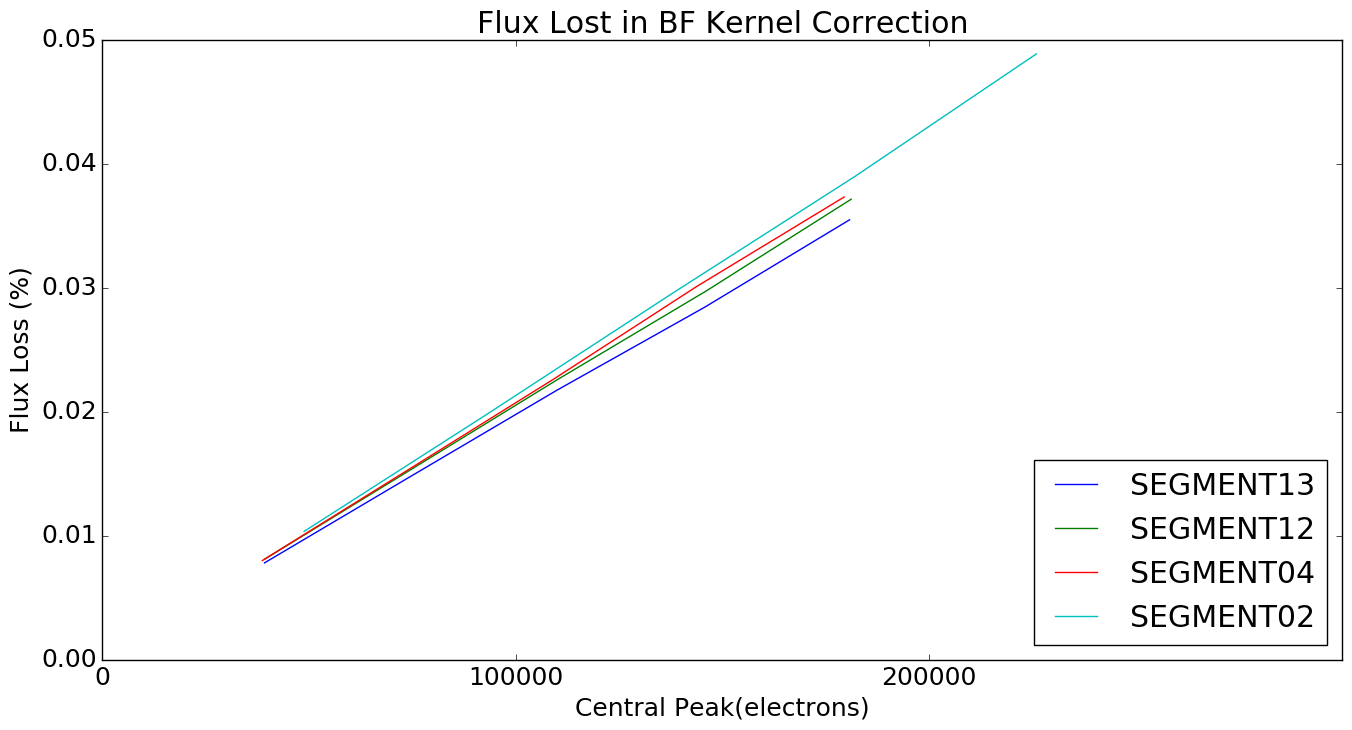

In [33]:
figure(figsize=(16,8))
title("Flux Lost in BF Kernel Correction")
for i, segmentnumber in enumerate([5,6,12,14]):
    hdr=pyfits.getheader(zfilelist[0],segmentnumber)
    extname = hdr['EXTNAME']
    flux_loss = (totelectrons[i,:] - corr_totelectrons[i,:]) / totelectrons[i,:] * 100.0
    print extname, flux_loss.max(), flux_loss.min()
    plot(imaxs[i,:], flux_loss, label = extname)

    xlim(0.0,300000.0)
    xticks([0,100000,200000])
    ylim(0.0, 0.05)
    xlabel('Central Peak(electrons)')
    ylabel('Flux Loss (%)')
legend(loc='lower right')
show()
